### Import python modules 

In [1]:
# 导入模块
import os
import math
import random
import numpy as np

import torch

import losses
import models

import utils, draw
from modeling_tools import *

random_state = 12314
torch.manual_seed(random_state) # cpu
np.random.seed(random_state)    # numpy
random.seed(random_state)       # random and transforms

os.environ['CUDA_VISIBLE_DEVICES']= '0,1,2,3'
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    num_GPU = torch.cuda.device_count()
    print(f"GPU 数量: {num_GPU}")
else:
    num_GPU = 1

print(f"运行平台: {device}")
root_path = os.path.abspath('.')

GPU 数量: 4
运行平台: cuda


### Load synthetic geologic models

In [2]:
dataset_name = "syn_train_valid_rgt"
dataset_path = os.path.join(root_path, "datasets", dataset_name)
                            
samples_train = np.load(os.path.join(dataset_path, 'samples_train.npy'), allow_pickle=True)
samples_valid = np.load(os.path.join(dataset_path, 'samples_valid.npy'), allow_pickle=True)

print(f"训练样本数量: {len(samples_train)}")
print(f"验证样本数量: {len(samples_valid)}")

possible_num_hrzs = [1,2,3]
hrz_grp = 4
bit = 256
bit_mute = 50
bit_rate = 2
fault_range = 1
norm=utils.min_max_norm

use_normal = False
input_attr_list = ["scalar", "fault"]
output_attr_list = ["rgt"]
if use_normal:
    input_attr_list.append("normal")
    output_attr_list.append("orientation")
    
print(f"输入属性:{input_attr_list}")
print(f"目标属性:{output_attr_list}")

训练样本数量: 4321
验证样本数量: 479
输入属性:['scalar', 'fault']
目标属性:['rgt']


### Parameters of data simulation 

In [3]:
train_sample_path = os.path.join(dataset_path, "train")
train_data =  utils.build_dataset_rgt(samples_train, train_sample_path, 'Train',
                                possible_num_hrzs, hrz_grp,
                                bit, bit_mute, bit_rate, 
                                fault_range,
                                use_normal=use_normal,
                                norm=norm)

['rgt', 'scalar', 'fault', 'mask_scalar']


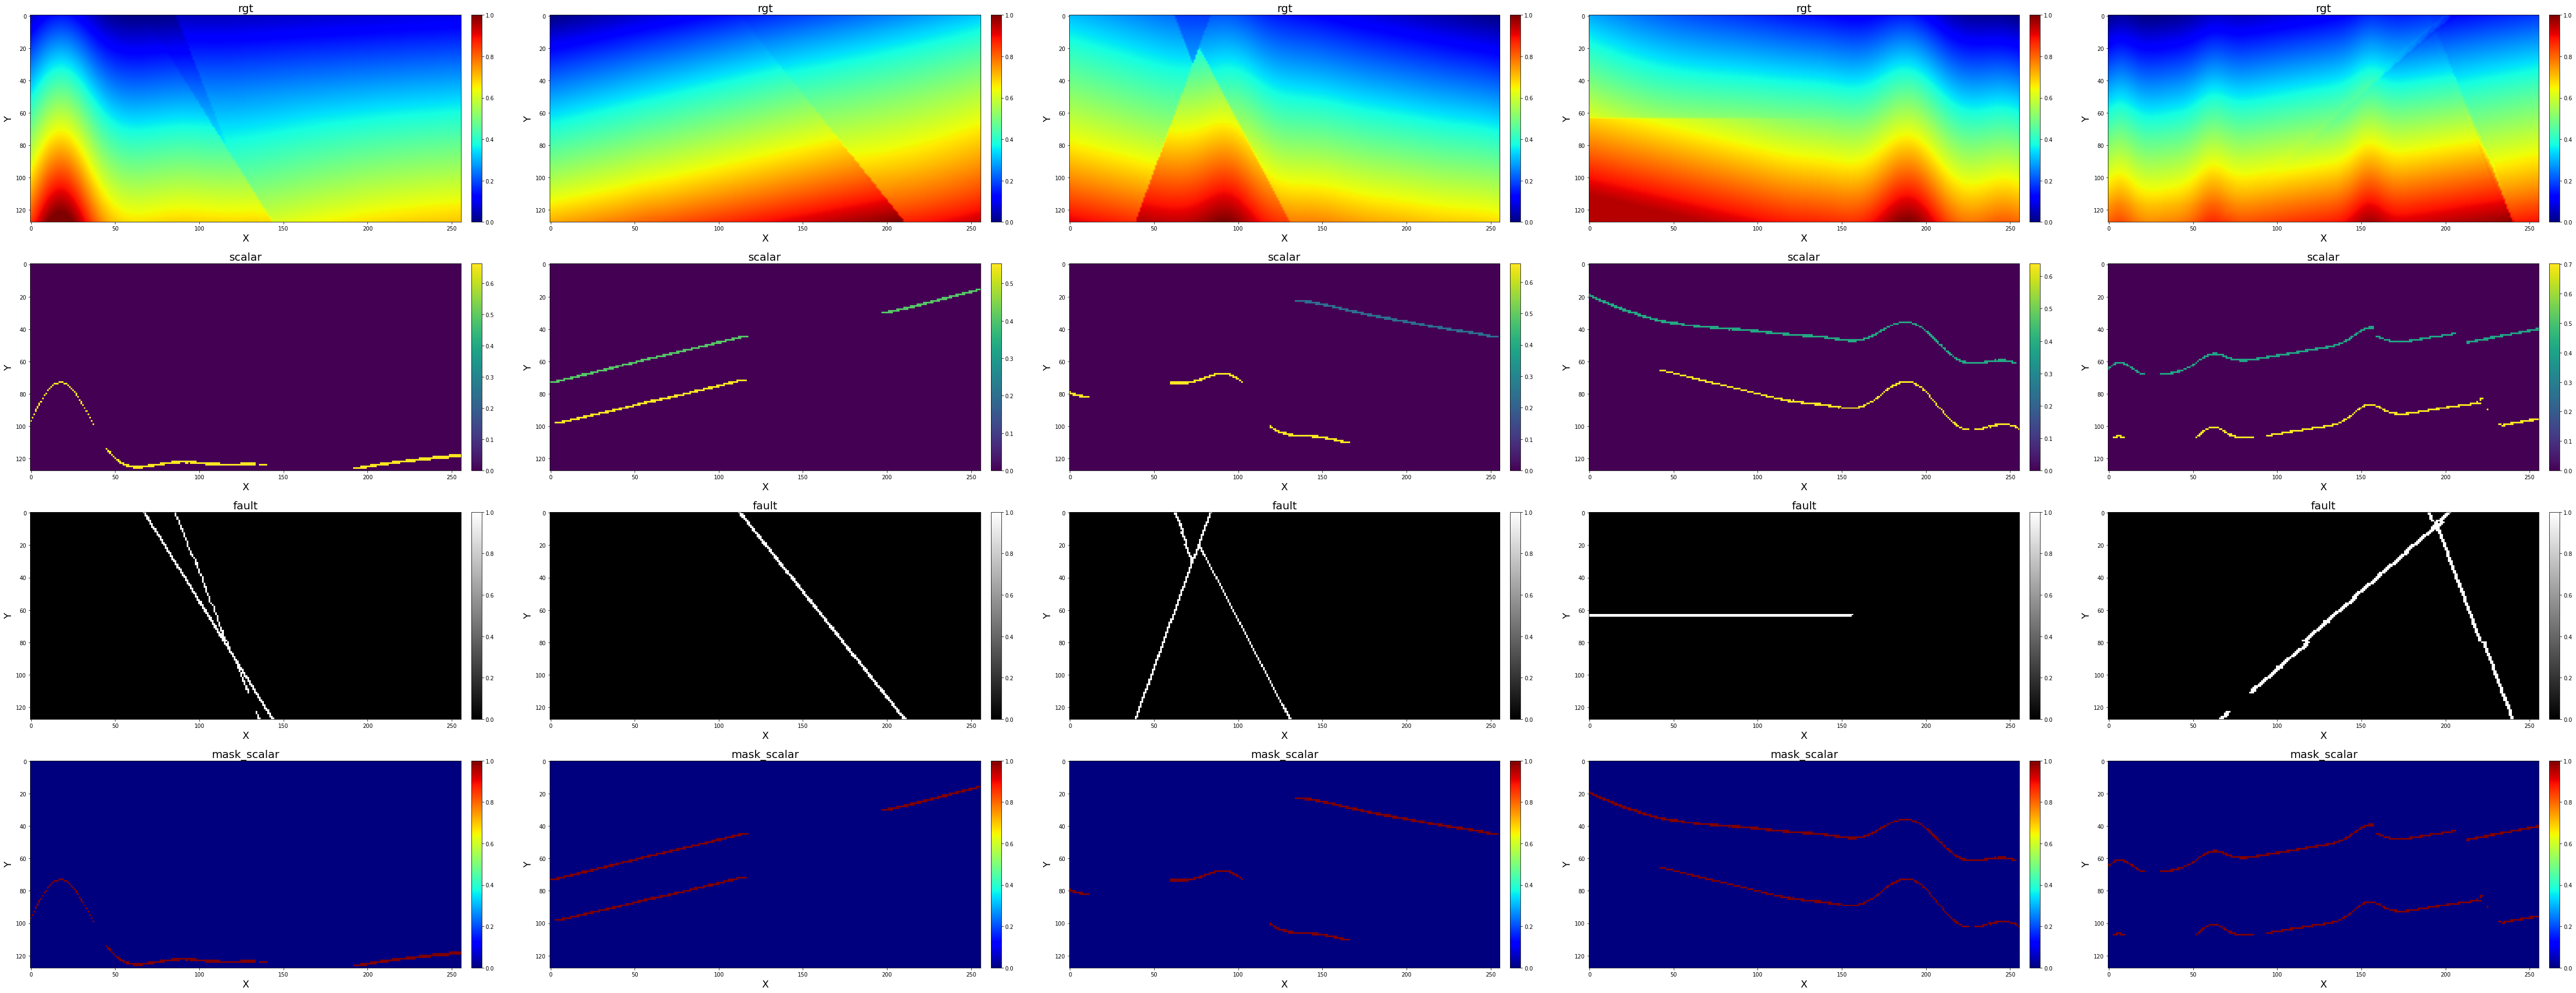

In [4]:
mask = True
batch_samples = [train_data[i] for i in range(100,105)]
draw_attr_list = output_attr_list + input_attr_list
if mask:
    draw_attr_list += ["mask_scalar"]
print(draw_attr_list)
draw.draw_samples(batch_samples, draw_attr_list)

### Training CNN

In [5]:
train_sample_path = os.path.join(dataset_path, "train")
train_data =  utils.build_dataset_rgt(samples_train, train_sample_path, 'Train',
                            possible_num_hrzs, hrz_grp,
                            bit, bit_mute, bit_rate, 
                            fault_range,
                            use_normal=use_normal,
                            norm=norm)

valid_data =  utils.build_dataset_rgt(samples_valid, train_sample_path, 'Valid',
                            possible_num_hrzs, hrz_grp,
                            bit, bit_mute, bit_rate, 
                            fault_range,
                            use_normal=use_normal,
                            norm=norm)

In [6]:
# 定义网络
inshape = (128,256)
param_model = {}
param_model['net_name'] = "ISMNet"
param_model['input_channels'] = 2 if not use_normal else 4
param_model['output_channels'] = 1
param_model['num_features'] = 1.0 
param_model['expansion'] = 1.5
param_model['inshape'] = inshape

model = getattr(models, param_model['net_name'])(param_model)

# 并行模式
if num_GPU > 1:
    print(f"多核模式")
    model = torch.nn.DataParallel(model, device_ids=range(num_GPU)).to(device)
else:
    print(f"单核模式")
        
model = model.to(device)

多核模式


In [7]:
# 定义训练参数
param = dict(param_model)
param['epochs'] = 121    # 训练轮数
param['batch_size'] = num_GPU * 80 # 批大小
param['inshape'] = inshape 
param['lr'] = 1e-2          # 学习率
param['optimizer_type'] = 'Adam' # 优化器类型
param['weight_decay'] = 0.0 # 权重衰减
param['decay_type'] = 'ReduceLROnPlateau' # 学习率衰减策略
param['gamma'] = 0.5    # 学习率衰减系数
param['lr_decay'] = 2   # 学习率衰减周期
param['disp_inter'] = 2 # 显示间隔
param['save_inter'] = 10 # 保存间隔
param['use_normal'] = use_normal

# param['loss_type'] = {"mae":0.24, "ms-ssim":0.84}
param['loss_type'] = {"ms-ssim":1.0}

loss_name = '+'.join([f"{'{:.2f}'.format(value)}*{key}" for key, value in param['loss_type'].items()])

# 模型保存路径    
session_name = '-'.join([param_model['net_name'], "dataset_"+dataset_name, loss_name])

if use_normal:
    session_name = '-'.join([session_name, "orientation"])                                        
                      
checkpoint_path = os.path.join('checkpoints', session_name)
param['checkpoint_path'] = checkpoint_path
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

print(f"模型读取路径: {checkpoint_path}")

模型读取路径: checkpoints/ISMNet-dataset_syn_train_valid_rgt-1.00*ms-ssim


In [ ]:
# 训练网络 
model = utils.train_valid_net(param, model, train_data, valid_data, plot=True, device=device)

Epoch:0, Training Loss:0.32611848 Validation Loss:0.32611848 Learning rate: 0.01000000
Epoch:2, Training Loss:0.06322103 Validation Loss:0.06322103 Learning rate: 0.01000000
Epoch:4, Training Loss:0.02569263 Validation Loss:0.02569263 Learning rate: 0.01000000
Epoch:6, Training Loss:0.01988906 Validation Loss:0.01988906 Learning rate: 0.01000000
Epoch:8, Training Loss:0.01659166 Validation Loss:0.01659166 Learning rate: 0.01000000
Epoch:10, Training Loss:0.01514735 Validation Loss:0.01514735 Learning rate: 0.01000000
Epoch:12, Training Loss:0.01374034 Validation Loss:0.01374034 Learning rate: 0.01000000
Epoch:14, Training Loss:0.01194644 Validation Loss:0.01194644 Learning rate: 0.01000000


### Inference

In [77]:
# 设置参数
dataset_name = "syn_train_valid_rgt"
dataset_category = 'samples_valid.npy'
dataset_path = os.path.join(root_path, "datasets", dataset_name)
samples_test = np.load(os.path.join(dataset_path, dataset_category), allow_pickle=True)
samples_test = samples_test[210:220]
print(f"测试样本数量: {len(samples_test)}")
check_data = True

测试样本数量: 10


In [78]:
# 读取数据
test_sample_path = os.path.join(dataset_path, "train")
test_data = utils.build_dataset_rgt(samples_test, test_sample_path, 'Infer',
                            possible_num_hrzs, hrz_grp,
                            bit, bit_mute, bit_rate, 
                            fault_range,
                            use_normal=use_normal,
                            norm=norm)

In [79]:
# 模型读取
checkpoint_file = os.path.join(checkpoint_path, 'checkpoint-best.pth')
print(f"模型读取路径: {checkpoint_file}")
if num_GPU == 1:
    utils.load_model_parameters(model, checkpoint_file, device)
else:
    model.load_state_dict(torch.load(checkpoint_file)['state_dict'])

模型读取路径: checkpoints/UNet-dataset_syn_train_valid_rgt-1.00*ms-ssim/checkpoint-best.pth


In [80]:
pred_samples = utils.pred(model, test_data, use_normal=use_normal, device=device)

['scalar', 'fault', 'rgt', 'pred', 'fitting']


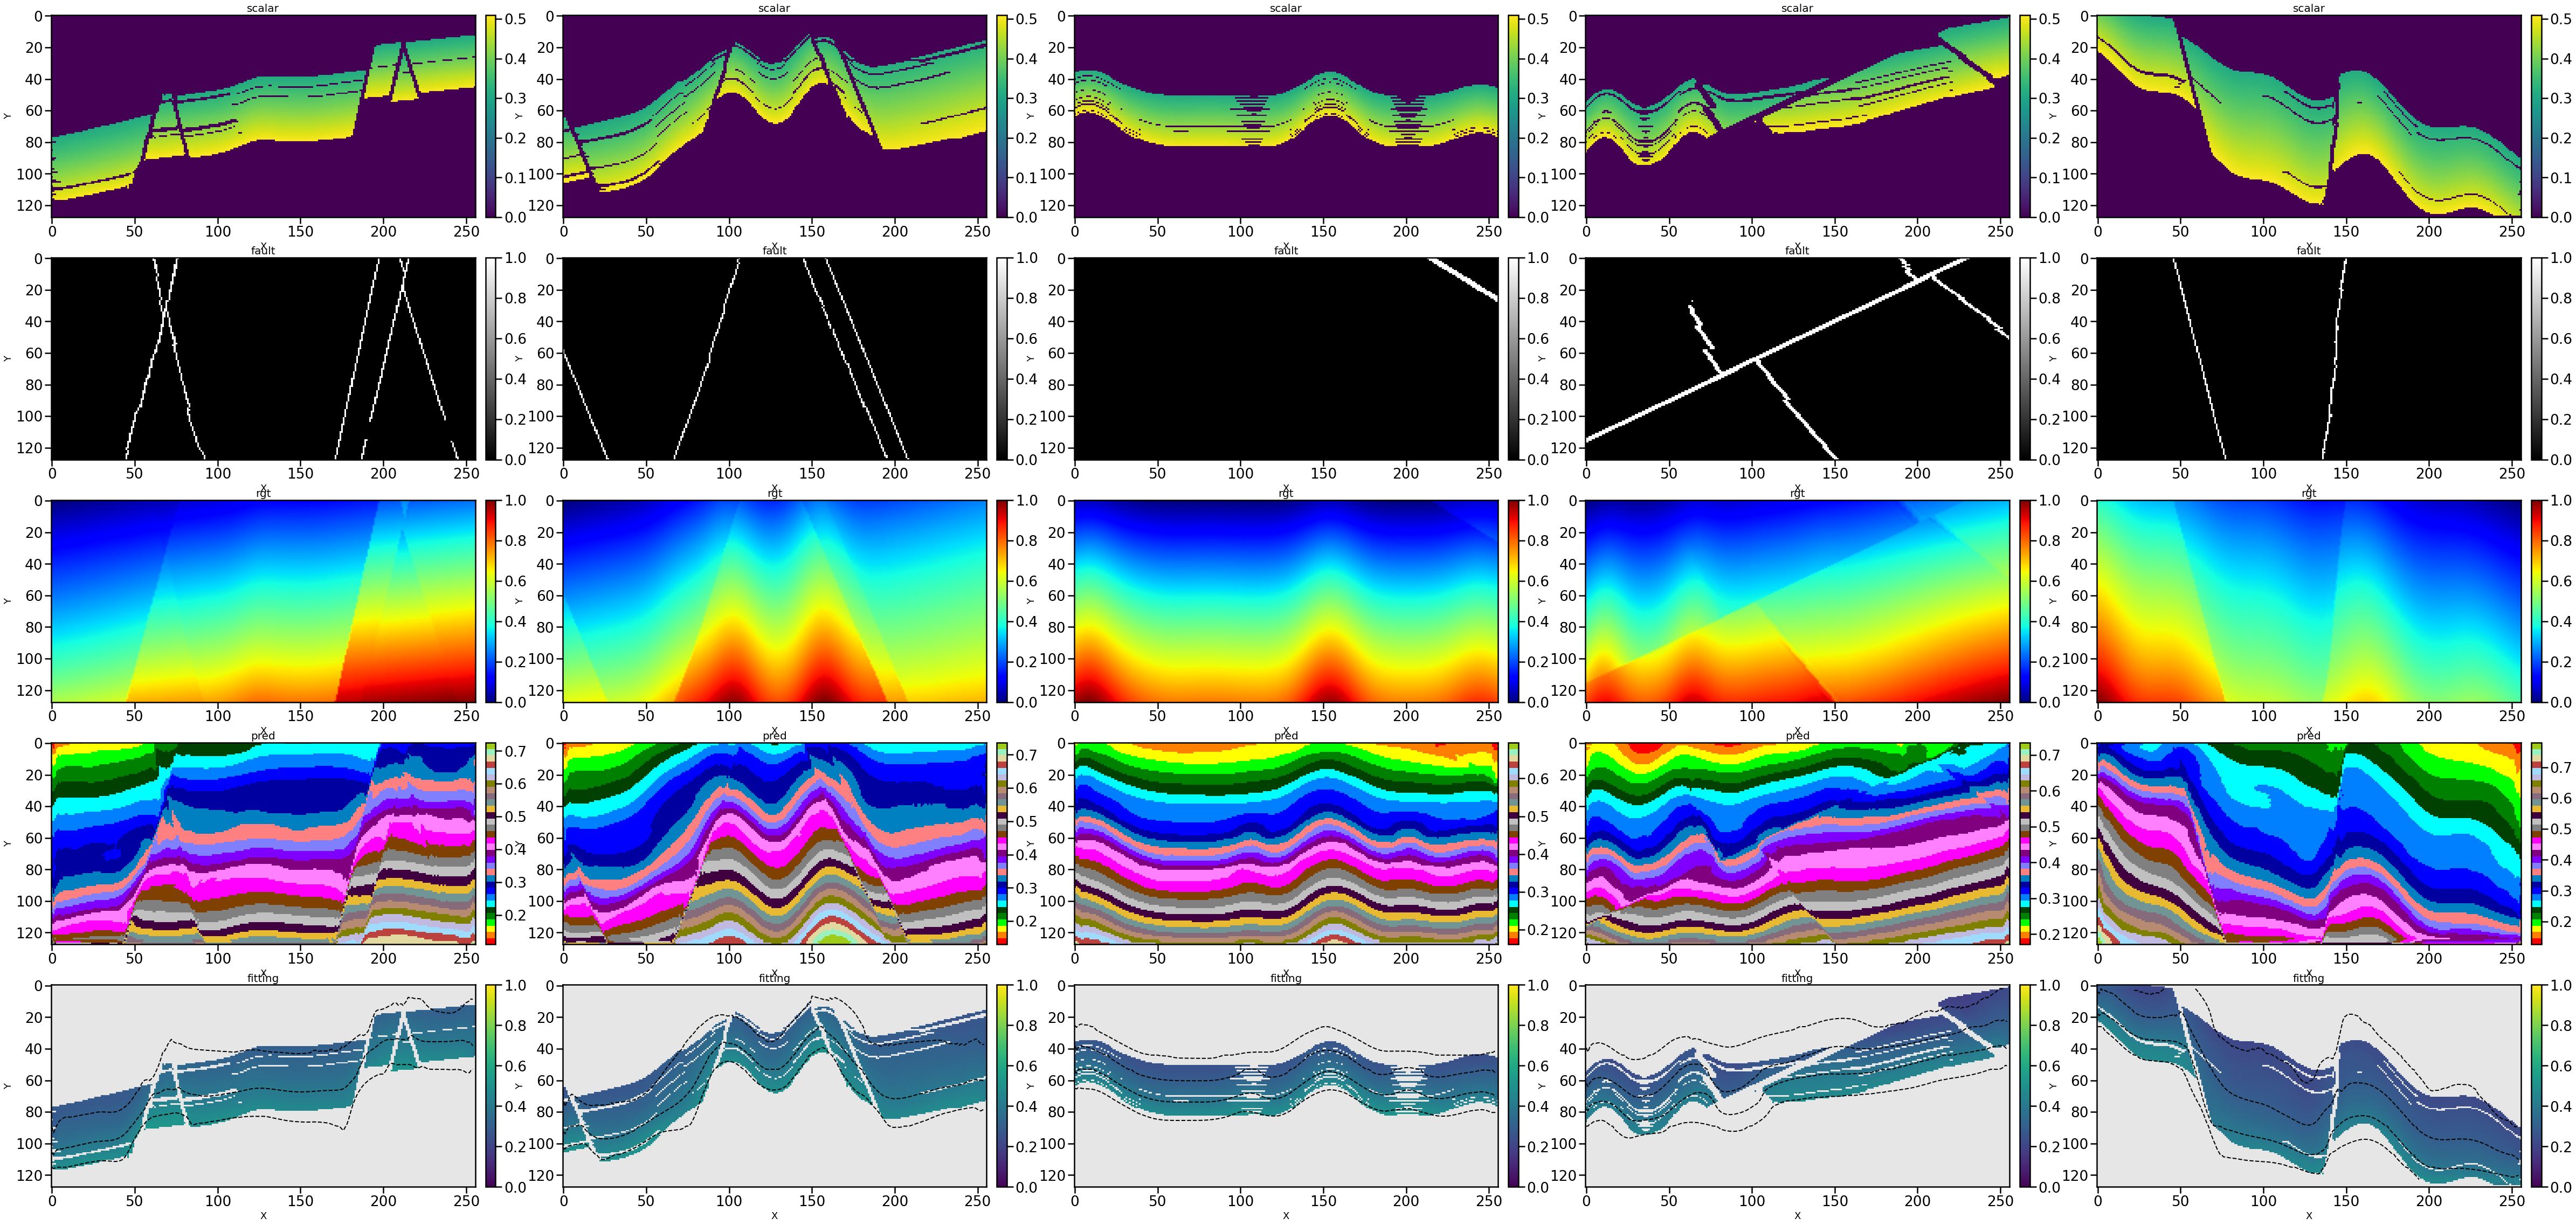

In [81]:
pred_attr_list = ["pred", "fitting"]
print(input_attr_list + output_attr_list + pred_attr_list)
draw.draw_samples(pred_samples[:5], input_attr_list + output_attr_list + pred_attr_list)

### Horizon Annotation Experiment

In [24]:
data_sample = np.load(os.path.join("raw_data", "hid_data_sample.npy"), allow_pickle=True).item()
mh1 = np.zeros(data_sample['frame'].shape)
mh2 = mh1.copy()
mh1[np.where( (data_sample['frame'] < 0.4) & (data_sample['frame'] > 0.0) )] = 1.0
mh2[np.where((data_sample['frame'] > 0.6) )] = 1.0

In [66]:
test_data_samples = []

test_sample = {}
a, b = 0.3, 0.5
test_sample['scalar'] = a * mh1 + b * mh2

# test_sample['scalar'] = 0.3 * mh1 + 0.5 * mh2
# test_sample['scalar'] = 0.4 * mh1 + 0.8 * mh2
# test_sample['scalar'] = 0.3 * mh1 + 0.6 * mh2
# test_sample['scalar'] = 0.4 * mh1 + 0.7 * mh2
# test_sample['scalar'] = 0.5 * mh1 + 0.8 * mh2

test_sample['fault'] = data_sample['fault']
test_sample['rgt'] = data_sample['rgt']

# rgt = utils.mea_std_norm(data_sample['rgt'])
# test_sample['scalar'] = data_sample['frame'].astype(np.bool).astype(np.float) * rgt


test_data_samples.append(test_sample)

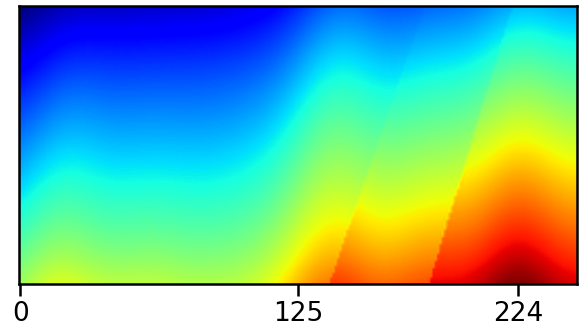

In [72]:
draw_img(test_data_samples[0]['rgt'][:125,5:], colorbar=False, interpolation='bilinear', 
         cmap='jet', save_file=f"rgt.png", yticks=False)

In [68]:
# draw_frame(test_data_samples[0]['fault'][:125,5:],
#          cmap='jet', save_file=f"fault.png")

In [69]:
# draw_frame(test_data_samples[0]['scalar'][:125,5:],
#          cmap='jet', save_file=f"frame_{a}_{b}.png")

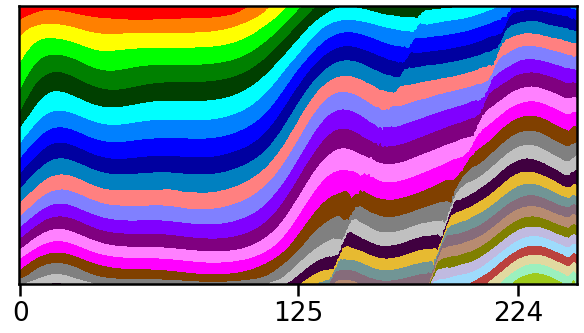

In [70]:
output_pred_samples = apply(model, test_data_samples, device=device)
draw_img(output_pred_samples[0]['pred'][:125,5:], colorbar=False, interpolation='bilinear', 
         cmap=my_cmap, save_file=f"pred_{a}_{b}.png", yticks=False)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lrs
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

def apply(model, test_data_samples, device=None):
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    output_pred_samples = [] 
    with torch.no_grad():
        for batch_idx, test_sample in enumerate(test_data_samples):

            # fault
            fault = torch.tensor(test_sample["fault"][np.newaxis,:,:]).float()
            fault = Variable(fault.unsqueeze(0).to(device))

            # rgt
            rgt = torch.tensor(test_sample["rgt"][np.newaxis,:,:]).float()
            rgt = Variable(rgt.unsqueeze(0).to(device))
            
            # scarlar
            scalar = torch.tensor(test_sample["scalar"][np.newaxis,:,:]).float()
            scalar = Variable(scalar.unsqueeze(0).to(device))            

            data = torch.cat((scalar, fault), dim=1)       
                
            rgt_i = model(data)
            
            pred_sample = {} 
            pred_sample["pred"] = rgt_i.cpu().squeeze(0).numpy()[0]
            pred_sample["rgt"] = test_sample["rgt"]   
            pred_sample["scalar"] = scalar.cpu().squeeze(0).numpy()[0]    
            pred_sample["fault"] = test_sample["fault"]   
            
            output_pred_samples.append(pred_sample)
            
    return output_pred_samples

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_context('poster',font_scale=1.2)
mpl.rc('figure',figsize=(10,12))

def min_max_norm(x):
    x = x - np.min(x)
    x = x / np.max(x)
    return x

def draw_img(img, msk=None, cmap="jet", 
             interpolation="bilinear", 
             vmin=None, vmax=None,
             save_file=None, 
             colorbar=False, yticks=True):
    fig, ax = plt.subplots()
    
    if vmin is None:
        vmin = np.min(img)
    if vmax is None:
        vmax = np.max(img)  
        
    plt.imshow(img,cmap=cmap, interpolation=interpolation, vmin=vmin, vmax=vmax)
    
    if msk is not None:
        plt.imshow(msk, alpha=0.4, cmap='jet', interpolation='nearest', yticks=False)
        
    if colorbar:
        cb = plt.colorbar(fraction=0.023,pad=0.02)  
        cb.set_ticks([vmin, (vmin+vmax)/2, vmax])
    
#     ax=plt.gca()
    ax.set_xticks([0,img.shape[1]//2,224])   
    ax.set_yticks([0,img.shape[0]//2,img.shape[0]-1])   
    ax.set_yticklabels([0,64,127])
    
    if not yticks:
        ax.set_yticks([])
                
    if save_file is not None:
        plt.savefig(os.path.join("fsyn", save_file), 
                    dpi=100, bbox_inches='tight')   
    plt.close    
    
def draw_frame(img_in, gray_fc=0.9, orientation=None, xy_pos=None, img_aux=None,
               cmap='jet', save_file=None, yticks=True):
    
    fig, ax = plt.subplots()
    img = img_in.copy()
    inshape = img_in.shape
    section = np.ones(inshape) * gray_fc
    
    img[img == 0.0] = np.nan   
    
    ax=plt.gca()
    ax.imshow(section, cmap='gray', vmin=0, vmax=1)
    ax.imshow(img, cmap=cmap, interpolation='nearest',
              vmin=0, vmax=1) 
    
    if img_aux is not None:
        img2 = 1 - img_aux.copy()
        img2[img2 == 1.0] = np.nan   
        ax.imshow(img2, interpolation='nearest', cmap='gray',
                  vmin=0, vmax=1)     
    
    if xy_pos is not None and orientation is not None:
        x2, y2 = xy_pos 
        u2, v2 = orientation[1][x2,y2], orientation[0][x2,y2]
        ax.quiver(y2,x2,-u2,v2, minshaft=1, minlength=1, headaxislength=4.5,
                   width=0.004, headwidth=3, headlength=5, color="maroon", alpha=0.8)
        
    ax.set_xticks([0,inshape[1]//2,224])   
    ax.set_yticks([0,inshape[0]//2,inshape[0]-1])   
    ax.set_yticklabels([0,64,127])
    
    if not yticks:
        ax.set_yticks([])       
    if save_file is not None:
        plt.savefig(os.path.join("fsyn", save_file), 
                    dpi=100, bbox_inches='tight')
    plt.close   

In [22]:
from matplotlib.colors import LinearSegmentedColormap

def get_cmap_xmw():
    
    text = '''private static Color[] getStrataColors(double alpha) {
        float a = (float)alpha;
        Color[] c = new Color[256];
        for (int i=0; i<256; i++) {
          if (i<8) {
            c[i] = new Color(1f,0f,0f,a);
          } else if (i<16) {
            c[i] = new Color(1f,0.5019608f,0f,a);
          } else if (i<24) {
            c[i] = new Color(1f,1f,0f,a);
          } else if (i<32) {
            c[i] = new Color(0f,1f,0f,a);
          } else if (i<40) {
            c[i] = new Color(0f,0.5019608f,0f,a);
          } else if (i<48) {
            c[i] = new Color(0f,0.2509804f,0f,a);
          } else if (i<56) {
            c[i] = new Color(0f,1f,1f,a);
          } else if (i<64) {
            c[i] = new Color(0f,0.5019608f,1f,a);
          } else if (i<72) {
            c[i] = new Color(0f,0f,1f,a);
          } else if (i<80) {
            c[i] = new Color(0f,0f,0.627451f,a);
          } else if (i<88) {
            c[i] = new Color(0f,0.5019608f,0.7529412f,a);
          } else if (i<96) {
            c[i] = new Color(1f,0.5019608f,0.5019608f,a);
          } else if (i<104) {
            c[i] = new Color(0.5019608f,0.5019608f,1f,a);
          } else if (i<112) {
            c[i] = new Color(0.5019608f,0f,1f,a);
          } else if (i<120) {
            c[i] = new Color(0.5019608f,0f,0.5019608f,a);
          } else if (i<128) {
            c[i] = new Color(1f,0.5019608f,1f,a);
          } else if (i<136) {
            c[i] = new Color(1f,0f,1f,a);
          } else if (i<144) {
            c[i] = new Color(0.5019608f,0.2509804f,0f,a);
          } else if (i<152) {
            c[i] = new Color(0.5019608f,0.5019608f,0.5019608f,a);
          } else if (i<160) {
            c[i] = new Color(0.7529412f,0.7529412f,0.7529412f,a);
          } else if (i<168) {
            c[i] = new Color(0.2509804f,0f,0.2509804f,a);
          } else if (i<176) {
            c[i] = new Color(0.90588236f,0.7294118f,0.19607843f,a);
          } else if (i<184) {
            c[i] = new Color(0.44313726f,0.58431375f,0.58431375f,a);
          } else if (i<192) {
            c[i] = new Color(0.5254902f,0.42352942f,0.4862745f,a);
          } else if (i<200) {
            c[i] = new Color(0.7176471f,0.54509807f,0.44313726f,a);
          } else if (i<208) {
            c[i] = new Color(0.5019608f,0.5019608f,0f,a);
          } else if (i<216) {
            c[i] = new Color(0.7529412f,0.7294118f,0.8784314f,a);
          } else if (i<224) {
            c[i] = new Color(0.61960787f,0.85882354f,0.9882353f,a);
          } else if (i<232) {
            c[i] = new Color(0.7372549f,0.25882354f,0.24705882f,a);
          } else if (i<240) {
            c[i] = new Color(0.8862745f,0.8509804f,0.627451f,a);
          } else if (i<248) {
            c[i] = new Color(0.60784316f,0.9411765f,0.7490196f,a);
          } else if (i<256) {
            c[i] = new Color(0.62352943f,0.79607844f,0.105882354f,a);
          }
        }
        return c;
      }'''    

    lines = text.split('\n')
    colors = []
    numb_pre  = 0
    for i in range(4,len(lines)-4,2):
        numb = lines[i].split('<')[-1].split(')')[0]
        numb = float(numb)/256.0

        line = lines[i+1].split('(')[-1].split(')')[0].split(',')[:3]    
              
        rgb = []
        for j in line:
            rgb.append(float(j[:-1]))
        colors.append((rgb[0],rgb[1],rgb[2]))
    
    return LinearSegmentedColormap.from_list('my_cmap', colors, N=len(colors))

my_cmap = get_cmap_xmw()